<div class="alert alert-block alert-info">
<p style="font-size:24px;text-align:center"><b>Propagate a low-resolution hand-crafted laser pulse through a thin lens.</b>
<br>We initialize the laser pulse from the <b>Off Peak Timing</b> experimental configuration.
</div>

In [1]:
import array
import math
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np
import os

from pykern.pkcollections import PKDict
# The rslaser library may not be installed, so a check is required.
try:
    import rslaser
except:
    print("The rslaser library was not found; installing from GitHub...")
    # Developers should use 'pip install -e .' from the command line.
    # Users can install directly from GitHub --
    !{sys.executable} -m pip install git+https://github.com/radiasoft/rslaser.git
    import rslaser
from rslaser.optics import wavefront
from rslaser.optics import element
from rslaser.utils import merit_functions
from rslaser.pulse import pulse

import scipy
from scipy import constants, ndimage, stats
from scipy.ndimage.filters import gaussian_filter

# SRW and srwlib (the corresponding Python API) are pre-installed on Sirepo/Jupyter
import srwlib
from srwlib import srwl

In [2]:
# 2D plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

# reset the notebook style
mpl.rcParams.update(mpl.rcParamsDefault)
%matplotlib inline

# Specify whether 2D and/or 3D plots should be rendered
RENDER_2D_PLOTS = True
RENDER_3D_PLOTS = False

# 3D plotting
if RENDER_3D_PLOTS:
    import plotly.graph_objects as go

In [3]:
# Let's read an image-pair of diagnostic data files to instantiate an SRW wavefront.
# First, we have to determine the file paths...
ccd_name = 'ccd_off_peak_timing.txt'
wfs_name = 'wfs_off_peak_timing.txt'

package_data_dir = rslaser.pkg_resources.resource_filename('rslaser','package_data')
ccd_path_to_file = os.path.join(package_data_dir, ccd_name)
wfs_path_to_file = os.path.join(package_data_dir, wfs_name)

# read the pixel size from the diagnostic metadata file
meta_file_name = 'wfs_meta.dat'
meta_path_to_file = os.path.join(package_data_dir, meta_file_name)
with open(meta_path_to_file) as fh:
    for line in fh:
        if line.startswith("pixel_size_h_microns"):
            pixel_size_h = float(line.split(":")[-1].split(",")[0])  # microns
        if line.startswith("pixel_size_v_microns"):
            pixel_size_v = float(line.split(":")[-1].split(",")[0])  # microns

# central wavelength of the laser pulse
lambda0_micron = 0.8

In [4]:
def rms_calc_2d(_x, _y, f_dist):
    """
    Calculate the x and y averages and RMS of a 2d distribution f_dist(x,y)

    Args:
        _x, 2d numpy array that defines x values of the distribution
        _y, 2d numpy array that defines y values of the distribution
        f_dist, 2d numpy array that defines the x,y distribution
    
    Returns:
        x_avg, y_avg, the average values of x and y
        x_rms, y_rms, the RMS values of x and y

    Example:
        >>> xavg, yavg, xrms, yrms = rms_calc_2d(my_array)
    """
    x_f = np.multiply(_x, f_dist)
    y_f = np.multiply(_y, f_dist)
    sum_f = np.sum(f_dist)
    x_avg = np.sum(x_f) / sum_f
    y_avg = np.sum(y_f) / sum_f

    xsq_f = np.multiply(_x, x_f)
    ysq_f = np.multiply(_y, y_f)
    x_std = np.sum(xsq_f) / sum_f
    y_std = np.sum(ysq_f) / sum_f

    x_rms = math.sqrt(x_std - x_avg**2)
    y_rms = math.sqrt(y_std - y_avg**2)
    return x_avg, y_avg, x_rms, y_rms

In [5]:
def nan_helper(_arr):
    """
    Clean unwanted NaNs from a numpy array, replacing them via interpolation.

    Args:
        _arr, numpy array with NaNs
    
    Returns:
        nans, logical indices of NaNs
        index, a function with signature indices = index(logical_indices)
               to convert logical indices of NaNs to 'equivalent' indices

    Example:
        >>> nans, x = nan_helper(my_array)
        >>> my_array[nans] = np.interp(x(nans), x(~nans), my_array[~nans])
    """
    return np.isnan(_arr), lambda z: z.nonzero()[0]

def array_cleaner(_arr, _ind):
    """
    Clean unwanted values from a numpy array, replacing them via interpolation.

    Args:
        _arr, numpy array with bad values
        _ind, precalculated indices of these bad values
    
    Returns:
        _arr, cleaned version of the input array

    Example:
        >>> indices = np.isnan(my_array)
        >>> my_array = array_cleaner(my_array, indices)
    """
    _arr[_ind] = np.nan
    nans, x = nan_helper(_arr)
    _arr[nans] = np.interp(x(nans), x(~nans), _arr[~nans])
    return _arr

In [6]:
# parse the intensity diagnostic data file
ccd_data = np.genfromtxt(ccd_path_to_file, skip_header=1)

# pad with zeros
ccd_temp = np.pad(ccd_data, 4, mode='constant')

# smooth the data
blur = 2
ccd_data = gaussian_filter(ccd_temp, sigma=blur)

# increase the magnitude
ccd_data *= 1.08e6

# create the x,y arrays with physical units based on the diagnostic pixel dimensions
x1_max = 0.5 * (ccd_data.shape[1] + 1.) * pixel_size_h * 1.e-6    # [m]
x1_min = -x1_max
x1_delta = 2.*x1_max / ccd_data.shape[1]
x1 = np.arange(x1_min, x1_max, x1_delta)

y1_max = 0.5 * (ccd_data.shape[0] + 1.) * pixel_size_v * 1.e-6    # [m]
y1_min = -y1_max
y1_delta = 2.*y1_max / ccd_data.shape[0]
y1 = np.arange(y1_min, y1_max, y1_delta)

x, y = np.meshgrid(x1, y1)

print('x1_min = ', x1_min)
print('x1_max = ', x1_max)

print('y1_min = ', y1_min)
print('y1_max = ', y1_max)

print('ccd_data.shape = ', ccd_data.shape)

x1_min =  -0.0028174999999999997
x1_max =  0.0028174999999999997
y1_min =  -0.0023062499999999997
y1_max =  0.0023062499999999997
ccd_data.shape =  (40, 48)


In [7]:
# Calculate intensity centroid and RMS values
xc, yc, xc_rms, yc_rms = rms_calc_2d(x, y, ccd_data)

In [8]:
# parse the measured phases of the wavefront
wfs_data = np.genfromtxt(wfs_path_to_file, skip_header=1, skip_footer=0)

# clean up any NaN's
indices = np.isnan(wfs_data)
wfs_data = array_cleaner(wfs_data, indices)

# pad with zeros
wfs_temp = np.pad(wfs_data, 4, mode='constant')

# smooth the data
blur = 4
wfs_data = gaussian_filter(wfs_temp, sigma=blur)

# convert from microns to radians
rad_per_micron = math.pi / lambda0_micron
wfs_data *= rad_per_micron

phi_min=np.min(wfs_data)
phi_max=np.max(wfs_data)

# we assume the WFS and CCD data are from the same diagnostic
# check that the data files have the same number of pixels
assert np.shape(wfs_data) == np.shape(ccd_data), error_message('ERROR -- WFS and CCD data have diferent shapes!!')

In [9]:
def wfs_ideal(x, y, xc, yc, phi_max, r0):
    """Idealized wavefront sensor (WFS) data.

    Args:
        x, y (2d array): horizontal and vertical positions for the wavefront phase data
        xc, yc (float): approximate center of the laser pulse
        phi_max (float): maximum value of the wavefront phase
        r0 (float): defines quadratic behavior for r<r_mid

    Returns:
        function values (2d array):  phase values of complex E-field in an electromagnetic wavefront
    """
    # calculate radius r, as well as r**2
    rsq = (x-xc)**2 + (y-yc)**2
    r = np.sqrt(rsq)
    
    return phi_max * (1. + rsq/r0**2)

In [10]:
# create a phase distribution that works well with SRW
# wfs_fit = wfs_data
r0 =  0.0013 # [m]
phi_max = -0.8e-3
wfs_fit = wfs_ideal(x, y, xc, yc, phi_max, r0)

# print(' wfs_fit = ', wfs_fit)

In [11]:
# create an idealized Gaussian distribution of intensities
ccd_fit = ccd_data
r_rms = 9.67e-04 * math.sqrt(2.) # [m]
ccd_fit = merit_functions.gaussian_ccd(x, y, 0., 0., 1.45e11, r_rms)

In [12]:
# e_norm = np.sqrt(ccd_data)
e_norm = np.sqrt(ccd_fit)
# ex_real = np.multiply(e_norm, np.cos(wfs_data)).flatten(order='C')
# ex_imag = np.multiply(e_norm, np.sin(wfs_data)).flatten(order='C')
ex_real = np.multiply(e_norm, np.cos(wfs_fit)).flatten(order='C')
ex_imag = np.multiply(e_norm, np.sin(wfs_fit)).flatten(order='C')

ex_numpy = np.zeros(2*len(ex_real))
for i in range(len(ex_real)):
    ex_numpy[2*i] = ex_real[i]
    ex_numpy[2*i+1] = ex_imag[i]

ex = array.array('f', ex_numpy.tolist())
ey = array.array('f', len(ex)*[0.])

In [13]:
wfr0 = srwlib.SRWLWfr(_arEx=ex, _arEy=ey, _typeE='f', 
                    _eStart=1.55, _eFin=1.55, _ne=1, 
                    _xStart=x1_min, _xFin=x1_max, _nx=np.shape(wfs_data)[0], 
                    _yStart=y1_min, _yFin=y1_max, _ny=np.shape(wfs_data)[1], 
                    _zStart=0., _partBeam=None)

Size of initial wavefront data array (coordinate): (40, 48)


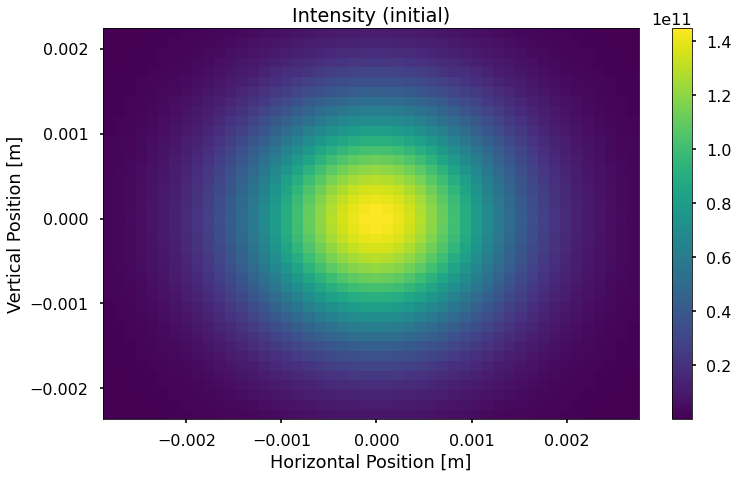

In [14]:
#Plot initial wavefront
##Initial wfr calculation
arIinit = srwlib.array('f', [0]*wfr0.mesh.nx*wfr0.mesh.ny) # "flat" array to take 2D intensity data
srwl.CalcIntFromElecField(arIinit, wfr0, 6, 0, 3, wfr0.mesh.eStart, 0, 0) #extracts intensity

##Reshaping electric field data from flat to 2D array
arIinit2D = np.array(arIinit).reshape((wfr0.mesh.nx, wfr0.mesh.ny), order='C')
wfrsizei=np.size(arIinit)

print('Size of initial wavefront data array (coordinate):',np.shape(arIinit2D))
xvalsf02=np.linspace(wfr0.mesh.xStart,wfr0.mesh.xFin,wfr0.mesh.nx)
yvalsf02=np.linspace(wfr0.mesh.yStart,wfr0.mesh.yFin,wfr0.mesh.ny)

if RENDER_2D_PLOTS:
    with plt.style.context(('seaborn-poster')):
        fig = plt.figure(figsize=(12,7.2))
        ax = fig.gca()
        plt.pcolormesh(x, y, arIinit2D, cmap=plt.cm.viridis, shading='auto')
        plt.colorbar()
        ax.set_ylabel(r'Vertical Position [m]')
        ax.set_xlabel(r'Horizontal Position [m]')
        ax.set_title('Intensity (initial)')

In [15]:
# initial phase
phase0 = srwlib.array('d', [0]*wfr0.mesh.nx*wfr0.mesh.ny) # "flat" array to take 2D intensity data
srwl.CalcIntFromElecField(phase0, wfr0, 0, 4, 3, wfr0.mesh.eStart, 0, 0) #extracts the phase; must use double precision

##Reshaping electric field data from flat to 2D array
phase_2d_0 = np.array(phase0).reshape((wfr0.mesh.nx, wfr0.mesh.ny), order='C')
wfrsize=np.size(phase0)

print('Size of initial wavefront data array (coordinate):',np.shape(phase_2d_0))
x0=np.linspace(wfr0.mesh.xStart,wfr0.mesh.xFin,wfr0.mesh.nx)
y0=np.linspace(wfr0.mesh.yStart,wfr0.mesh.yFin,wfr0.mesh.ny)

Size of initial wavefront data array (coordinate): (40, 48)


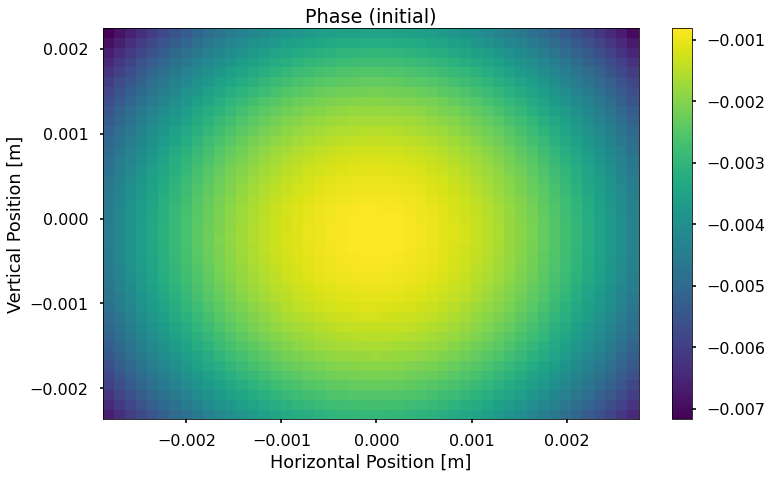

In [16]:
# plot the phase
if RENDER_2D_PLOTS:
    with plt.style.context(('seaborn-poster')):
        fig = plt.figure(figsize=(12,7.2))
        ax = fig.gca()
        plt.pcolormesh(x, y, phase_2d_0, cmap=plt.cm.viridis, shading='auto')
        plt.colorbar()
        ax.set_xlabel(r'Horizontal Position [m]')
        ax.set_ylabel(r'Vertical Position [m]')
        ax.set_title('Phase (initial)')

In [17]:
# we need to know the wavefront centroid and rms properties
x_avg, y_avg, x_rms, y_rms = rms_calc_2d(x, y, arIinit2D)

print(' x_avg = {0:4.2e} [m]'.format(x_avg))
print(' y_avg = {0:4.2e} [m]'.format(y_avg))
print(' ')
print(' x_rms = {0:4.2e} [m]'.format(x_rms))
print(' y_rms = {0:4.2e} [m]'.format(y_rms))

wfr0.xc = x_avg       # transverse coordinate of wavefront "source center"
wfr0.yc = y_avg       # transverse coordinate of wavefront "source center"

wfr0.Rx = -r0          # wavefront radius
wfr0.Ry = -r0          # wavefront radius
# wfr0.Rx = -0.0099227          # wavefront radius
# wfr0.Ry = -0.0099227          # wavefront radius
wfr0.dRx = 0.
wfr0.dRy = 0.
# wfr0.dRx = 9.9227e-5
# wfr0.dRy = 9.9227e-5

wfr0.arMomX =  array.array('d', [840390541312.0, 7.364840065487388e-20, -1.4058507076697424e-05, 2.7263433550047373e-20, -1.4058507076697424e-05, 6.471726123891131e-07, -6.522995681734756e-05, 0.006574756931513548, 6.471726123891131e-07, -6.522995681734756e-05, 0.006574756931513548])
wfr0.arElecPropMatr =  array.array('d', [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0])

wfr0.avgPhotEn = 1.55    # average photon energy for time-domain simulations
wfr0.numTypeElFld =  b'f'

 x_avg = -1.96e-06 [m]
 y_avg = -6.50e-06 [m]
 
 x_rms = 9.51e-04 [m]
 y_rms = 9.11e-04 [m]


In [18]:
# create a laser pulse, using the wavefront created above

# photon energy corresponding to lambda = 1 micron
_LASER_PULSE_SLICE = PKDict(
    sigrW = math.sqrt(x_rms*y_rms),
    propLen = 15,
    pulseE = 0.001,
    poltype = 1,
    sampFact = 0.002,
    mx = 0,
    my = 0
)
_LASER_PULSE = PKDict(
        phE = 1.55,
        nslice = 1,
        chirp = 0,
        w0 = 2.*math.sqrt(x_rms*y_rms),
        a0 = .002,
        dw0x = 0.0,
        dw0y = 0.0,
        z_waist = -0.1,
        dzwx = 0.0,
        dzwy = 0.0,
        tau_fwhm = 0.1 / constants.c / math.sqrt(2.),
        z_center = 0.,
        x_shift = 0.,
        y_shift = 0.,
        d_to_w = 0.1,
        slice_params=_LASER_PULSE_SLICE,
)

In [19]:
# instantiate the laser pulse (this can take a few seconds)
in_pulse = PKDict(
    **_LASER_PULSE
    )
LP = pulse.LaserPulse(in_pulse)

slice=LP.slice
slice[0].wfr = wfr0

print(' nx = ', LP.slice[0].wfr.mesh.nx)
print(' ny = ', LP.slice[0].wfr.mesh.ny)
print(' ne = ', LP.slice[0].wfr.mesh.ne)
print(' ')
print(' xStart = ', LP.slice[0].wfr.mesh.xStart)
print(' xFin = ', LP.slice[0].wfr.mesh.xFin)
print(' yStart = ', LP.slice[0].wfr.mesh.yStart)
print(' yFin = ', LP.slice[0].wfr.mesh.yFin)
print(' eStart = ', LP.slice[0].wfr.mesh.eStart)
print(' eFin = ', LP.slice[0].wfr.mesh.eFin)
print(' zStart = ', LP.slice[0].wfr.mesh.zStart)
print(' ')
print(' nvx = ', LP.slice[0].wfr.mesh.nvx)
print(' nvy = ', LP.slice[0].wfr.mesh.nvy)
print(' nvz = ', LP.slice[0].wfr.mesh.nvz)
print(' hvx = ', LP.slice[0].wfr.mesh.hvx)
print(' hvy = ', LP.slice[0].wfr.mesh.hvy)
print(' hvz = ', LP.slice[0].wfr.mesh.hvz)
print(' arSurf = ', LP.slice[0].wfr.mesh.arSurf)
print(' ')
print(' avgPhotEn = ', LP.slice[0].wfr.avgPhotEn)
print(' presCA = ', LP.slice[0].wfr.presCA)
print(' presFT = ', LP.slice[0].wfr.presFT)
print(' unitElFld = ', LP.slice[0].wfr.unitElFld)
print(' unitElFldAng = ', LP.slice[0].wfr.unitElFldAng)
print(' ')
print(' Rx = ', LP.slice[0].wfr.Rx)
print(' Ry = ', LP.slice[0].wfr.Ry)
print(' dRx = ', LP.slice[0].wfr.dRx)
print(' dRy = ', LP.slice[0].wfr.dRy)
print(' xc = ', LP.slice[0].wfr.xc)
print(' yc = ', LP.slice[0].wfr.yc)
print(' ')
print(' numTypeElFld = ', LP.slice[0].wfr.numTypeElFld)
print(' partBeam = ', LP.slice[0].wfr.partBeam)
print(' arElecPropMatr = ', LP.slice[0].wfr.arElecPropMatr)
print(' arMomX = ', LP.slice[0].wfr.arMomX)
print(' arMomY = ', LP.slice[0].wfr.arMomY)
print(' arWfrAuxData = ', LP.slice[0].wfr.arWfrAuxData)

 nx =  40
 ny =  48
 ne =  1
 
 xStart =  -0.0028174999999999997
 xFin =  0.0028174999999999997
 yStart =  -0.0023062499999999997
 yFin =  0.0023062499999999997
 eStart =  1.55
 eFin =  1.55
 zStart =  0.0
 
 nvx =  0
 nvy =  0
 nvz =  1
 hvx =  1
 hvy =  0
 hvz =  0
 arSurf =  None
 
 avgPhotEn =  1.55
 presCA =  0
 presFT =  0
 unitElFld =  1
 unitElFldAng =  0
 
 Rx =  -0.0013
 Ry =  -0.0013
 dRx =  0.0
 dRy =  0.0
 xc =  -1.9639524541155144e-06
 yc =  -6.496394696918369e-06
 
 numTypeElFld =  b'f'
 partBeam =  <srwlib.SRWLPartBeam object at 0x7f0f66119160>
 arElecPropMatr =  array('d', [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0])
 arMomX =  array('d', [840390541312.0, 7.364840065487388e-20, -1.4058507076697424e-05, 2.7263433550047373e-20, -1.4058507076697424e-05, 6.471726123891131e-07, -6.522995681734756e-05, 0.006574756931513548, 6.471726123891131e-07, -6.522995681734756e-05, 0.006574756931513548])
 arMomY =  array('d', [0.0

In [20]:
# look at the horizontal electric field
print(' min(wfr0.arEx) = ', np.min(wfr0.arEx))
print(' max(wfr0.arEx) = ', np.max(wfr0.arEx))

 min(wfr0.arEx) =  -448.86935
 max(wfr0.arEx) =  380788.53


<div class="alert alert-block alert-info">
<p style="font-size:18px;">Create a simple focusing lens and propagate the laser pulse.</p>
</div>

In [21]:
# instantiate a simple focusing lens
focal_length = 20.   # [m]
lattice_lens = [(element.Lens(focal_length),'default')]

# propagate the pulse through the lattice
for iterator in lattice_lens:
    current_elem, prop_type = iterator
    LP = current_elem.propagate(LP, prop_type)

In [22]:
# transmitted pulse - intensity
wfr2=LP.slice[0].wfr

intensity2 = srwlib.array('f', [0]*wfr2.mesh.nx*wfr2.mesh.ny) # "flat" array to take 2D intensity data
srwl.CalcIntFromElecField(intensity2, wfr2, 0, 0, 3, wfr2.mesh.eStart, 0, 0) #extracts intensity

##Reshaping electric field data from flat to 2D array
intens_2d_2 = np.array(intensity2).reshape((wfr2.mesh.nx, wfr2.mesh.ny), order='C')
wfrsizei=np.size(intensity2)

print('Size of initial wavefront data array (coordinate):',np.shape(intens_2d_2))
x2=np.linspace(wfr2.mesh.xStart,wfr2.mesh.xFin,wfr2.mesh.nx)
y2=np.linspace(wfr2.mesh.yStart,wfr2.mesh.yFin,wfr2.mesh.ny)

Size of initial wavefront data array (coordinate): (40, 48)


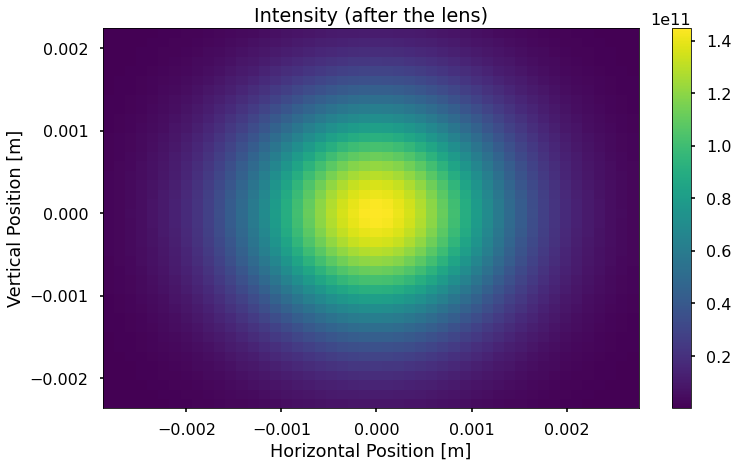

In [23]:
# plot the computed intensity
if RENDER_2D_PLOTS:
    with plt.style.context(('seaborn-poster')):
        fig = plt.figure(figsize=(12,7))
        ax = fig.gca()

        # By setting wfr0a.unitElFldAng=1, default units should  now be in mrad(?)
        plt.pcolormesh(x, y, intens_2d_2, cmap=plt.cm.viridis,shading='auto')
        plt.colorbar()
        ax.set_ylabel(r'Vertical Position [m]')
        ax.set_xlabel(r'Horizontal Position [m]')
        ax.set_title('Intensity (after the lens)')

In [24]:
# transmitted pulse - phase
phase2 = srwlib.array('d', [0]*wfr2.mesh.nx*wfr2.mesh.ny) # "flat" array to take 2D intensity data
srwl.CalcIntFromElecField(phase2, wfr2, 0, 4, 3, wfr2.mesh.eStart, 0, 0) #extracts the phase; must use double precision

##Reshaping electric field data from flat to 2D array
phase_2d_2 = np.array(phase2).reshape((wfr2.mesh.nx, wfr2.mesh.ny), order='C')
wfrsize=np.size(phase2)

print('Size of initial wavefront data array (coordinate):',np.shape(phase_2d_2))
x2=np.linspace(wfr2.mesh.xStart,wfr2.mesh.xFin,wfr2.mesh.nx)
y2=np.linspace(wfr2.mesh.yStart,wfr2.mesh.yFin,wfr2.mesh.ny)

# print(' ')
# print(' phase_2d_2 = ', phase_2d_2)

Size of initial wavefront data array (coordinate): (40, 48)


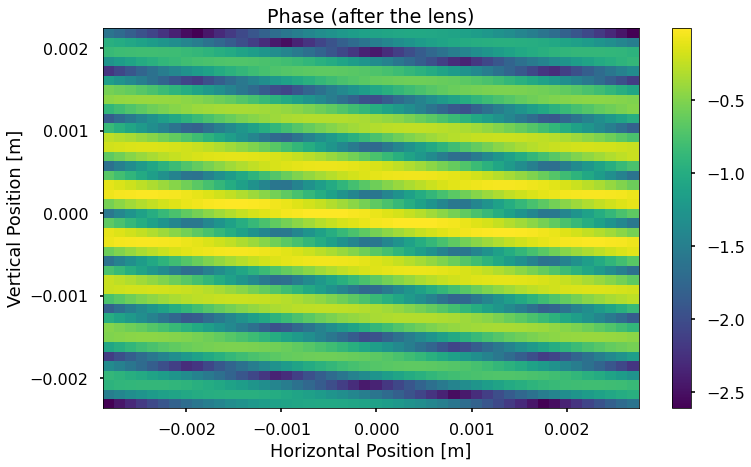

In [25]:
# plot the phase
if RENDER_2D_PLOTS:
    with plt.style.context(('seaborn-poster')):
        fig = plt.figure(figsize=(12,7))
        ax = fig.gca()

        # By setting wfr0a.unitElFldAng=1, default units should  now be in mrad(?)
        plt.pcolormesh(x, y, phase_2d_2, cmap=plt.cm.viridis,shading='auto')
        plt.colorbar()
        ax.set_ylabel(r'Vertical Position [m]')
        ax.set_xlabel(r'Horizontal Position [m]')
        ax.set_title('Phase (after the lens)')

In [26]:
print(' nx = ', LP.slice[0].wfr.mesh.nx)
print(' ny = ', LP.slice[0].wfr.mesh.ny)
print(' ne = ', LP.slice[0].wfr.mesh.ne)
print(' ')
print(' xStart = ', LP.slice[0].wfr.mesh.xStart)
print(' xFin = ', LP.slice[0].wfr.mesh.xFin)
print(' yStart = ', LP.slice[0].wfr.mesh.yStart)
print(' yFin = ', LP.slice[0].wfr.mesh.yFin)
print(' eStart = ', LP.slice[0].wfr.mesh.eStart)
print(' eFin = ', LP.slice[0].wfr.mesh.eFin)
print(' zStart = ', LP.slice[0].wfr.mesh.zStart)
print(' ')
print(' nvx = ', LP.slice[0].wfr.mesh.nvx)
print(' nvy = ', LP.slice[0].wfr.mesh.nvy)
print(' nvz = ', LP.slice[0].wfr.mesh.nvz)
print(' hvx = ', LP.slice[0].wfr.mesh.hvx)
print(' hvy = ', LP.slice[0].wfr.mesh.hvy)
print(' hvz = ', LP.slice[0].wfr.mesh.hvz)
print(' arSurf = ', LP.slice[0].wfr.mesh.arSurf)
print(' ')
print(' avgPhotEn = ', LP.slice[0].wfr.avgPhotEn)
print(' presCA = ', LP.slice[0].wfr.presCA)
print(' presFT = ', LP.slice[0].wfr.presFT)
print(' unitElFld = ', LP.slice[0].wfr.unitElFld)
print(' unitElFldAng = ', LP.slice[0].wfr.unitElFldAng)
print(' ')
print(' Rx = ', LP.slice[0].wfr.Rx)
print(' Ry = ', LP.slice[0].wfr.Ry)
print(' dRx = ', LP.slice[0].wfr.dRx)
print(' dRy = ', LP.slice[0].wfr.dRy)
print(' xc = ', LP.slice[0].wfr.xc)
print(' yc = ', LP.slice[0].wfr.yc)
print(' ')
print(' numTypeElFld = ', LP.slice[0].wfr.numTypeElFld)
print(' partBeam = ', LP.slice[0].wfr.partBeam)
print(' arElecPropMatr = ', LP.slice[0].wfr.arElecPropMatr)
print(' arMomX = ', LP.slice[0].wfr.arMomX)
print(' arMomY = ', LP.slice[0].wfr.arMomY)
print(' arWfrAuxData = ', LP.slice[0].wfr.arWfrAuxData)

 nx =  40
 ny =  48
 ne =  1
 
 xStart =  -0.0028174999999999997
 xFin =  0.0028174999999999997
 yStart =  -0.0023062499999999997
 yFin =  0.0023062499999999997
 eStart =  1.55
 eFin =  1.55
 zStart =  0.0
 
 nvx =  0
 nvy =  0
 nvz =  1
 hvx =  1
 hvy =  0
 hvz =  0
 arSurf =  None
 
 avgPhotEn =  1.55
 presCA =  0
 presFT =  0
 unitElFld =  1
 unitElFldAng =  0
 
 Rx =  -0.001299915505492143
 Ry =  -0.001299915505492143
 dRx =  0.0001299915505492143
 dRy =  0.0001299915505492143
 xc =  -1.9638248055031564e-06
 yc =  -6.495972458708552e-06
 
 numTypeElFld =  b'f'
 partBeam =  <srwlib.SRWLPartBeam object at 0x7f0f66119160>
 arElecPropMatr =  array('d', [1.0, 0.0, 0.0, 0.0, -0.05, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, -0.05, 1.0, 0.0, 0.0, 0.0, 0.0])
 arMomX =  array('d', [840390541312.0, 7.364840065487388e-20, -1.4058507076697427e-05, 2.7263433550047373e-20, -1.4058507076697426e-05, 6.471726123891131e-07, -6.526231544796701e-05, 0.006581281545126814, 6.471726123891131e-07, -6.52

In [27]:
# look at the horizontal electric field
print(' min(wfr2.arEx) = ', np.min(wfr2.arEx))
print(' max(wfr2.arEx) = ', np.max(wfr2.arEx))

 min(wfr2.arEx) =  -375384.5
 max(wfr2.arEx) =  379436.2
